# Explorative Data Analysis
## Introduction
This master thesis investigates time-stamped observability signals collected from the infrastructure (platform) Kubernetes cluster, focusing on numeric metrics (Prometheus) and textual logs (Loki). Signals are ingested via an observability pipeline using the OpenTelemetry Collector to gather, transform, and ship data to centralized storage. A simplified architecture of this pipeline is depicted below.

![observability-signals-pipeline](./img/observability-signals-pipeline.png)

Given the distributed nature of Kubernetes and the complexity of the ingestion pipeline, some observations may be missing. Throughout this study, missing observations are treated as absence of data rather than null values. In practice, Prometheus and Loki do not ingest explicit nulls; therefore, we assume that when a series or stream is present, it contains concrete values, and when absent, the issue likely originates from upstream collection, transport, or storage components.

## Scope and Objectives
- Characterize the structure and statistical properties of Prometheus metrics (numeric time series) and Loki logs (string-valued events) produced by platform services (observability stack, authentication/authorization, CI/CD tooling, ingress, and related system components).
- Quantify label distributions, cardinalities, and patterns across infrastructure namespaces, service classes, and workload types (excluding product/application namespaces).
- Provide guidance for feature engineering and model-ready representations tailored to infrastructure reliability and operations analytics.
- Explicitly exclude application/product workloads and business-domain metrics/logs; the analysis is limited to the infrastructure cluster.

## Data Characteristics
Observations in both systems are associated with a timestamp, a set of labels and a value. For Prometheus, values are numeric (integer or float), representing counters, gauges, or derived rates. For Loki, values are strings whose formats depend on application logging conventions (e.g., JSON, logfmt, or plaintext). Labels encode contextual metadata (e.g., namespace, pod, container, component), enabling grouping and filtering across heterogeneous platform services. Limiting scope to infrastructure services focuses the analysis on platform reliability, resource utilization, and systemic health signals rather than application-level semantics.

# Exploration
In the following sections, we examine Prometheus and Loki data currently stored in the production infrastructure environment. We first describe their data models and labeling schemes, then perform exploratory analyses of volumes, cardinalities, temporal dynamics, and representative samples. These results inform subsequent preprocessing steps and the selection of robust features for downstream data science tasks.

## Prometheus


Below we summarize the number of time series per metric name returned by the earlier query (infrastructure cluster and monitoring namesapce constrained). We examine:
- Absolute counts sorted descending (Top-N focus).
- Long tail characteristics via cumulative coverage.
- Log-scaled distribution to highlight smaller metrics.
These views help identify high-cardinality or high-volume metric families (e.g., HTTP server buckets) and very low-volume control/process metrics (e.g., OpenTelemetry collector internals).


In [6]:
# import libraries
import pandas as pd
from prometheus_api_client import PrometheusConnect
import matplotlib.pyplot as plt

In [7]:
# configure Prometheus connection and test it
prom = PrometheusConnect(url='http://localhost:3001', disable_ssl=True)
print("Connected to Prometheus:", prom.check_prometheus_connection())

Connected to Prometheus: True


### Time-Series

In [8]:
# Query metric count by name 
query_metric_names = prom.custom_query(query='count by (__name__) ({__name__!="",cluster=~".*infra"})')
metric_names = {}
for entry in query_metric_names:
    metric_names[entry['metric']['__name__']] = entry['value'][1]

In [9]:
# Build DataFrame from metric_names and display
metric_df = (pd.Series(metric_names, name='count')
              .astype(int)
              .rename_axis('metric')
              .reset_index()
              .sort_values('count', ascending=False))

# Compute cumulative coverage and show head
total = metric_df['count'].sum()
metric_df['cumulative'] = metric_df['count'].cumsum() / total

print(f'Total metrics: {len(metric_df)}')
print(f'Total timeseries across metrics: {total}')
metric_df.head()

Total metrics: 2886
Total timeseries across metrics: 258429


,metric,count,cumulative
2842,azure_api_service_status,20535,0.079461
2843,azure_api_service_uptime,20535,0.158922
1669,loki_tsdb_shipper_table_sync_latency_seconds_b...,20040,0.236467
1657,loki_tsdb_shipper_query_wait_time_seconds_bucket,20040,0.314013
56,prober_probe_duration_seconds_bucket,3012,0.325668


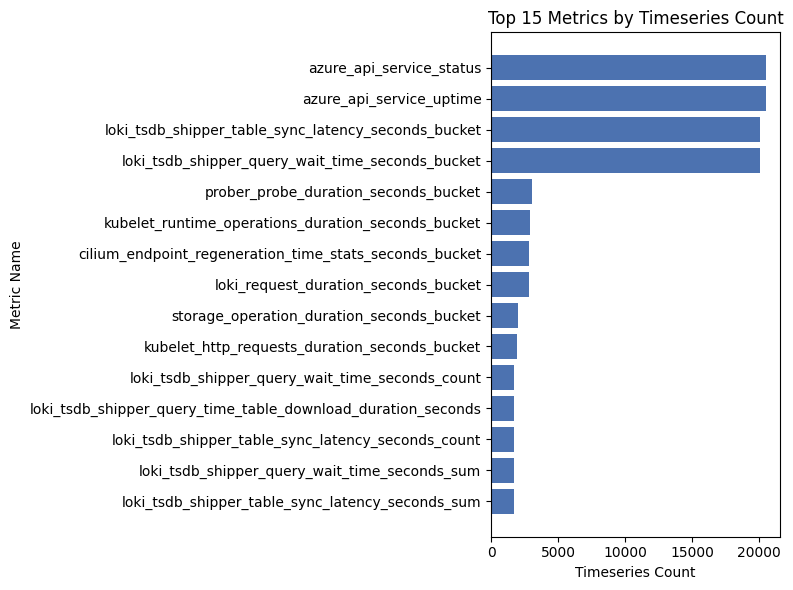

In [10]:
# Plot 1: Top-N absolute counts
top_n = 15
top_df = metric_df.head(top_n)

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(top_df['metric'][::-1], top_df['count'][::-1], color='#4C72B0')
ax.set_title(f'Top {top_n} Metrics by Timeseries Count')
ax.set_xlabel('Timeseries Count')
ax.set_ylabel('Metric Name')
plt.tight_layout()
plt.show()

In this initial exploration of the Prometheus data, we observe a broad spectrum of available metrics and time series that could serve as candidate inputs for the modeling tasks in this thesis. As the analysis progresses, we narrow our focus to a set of aggregated, infrastructure-level indicators of service health (e.g., CPU and memory utilization, network traffic) that provide stable and interpretable signals across platform components.

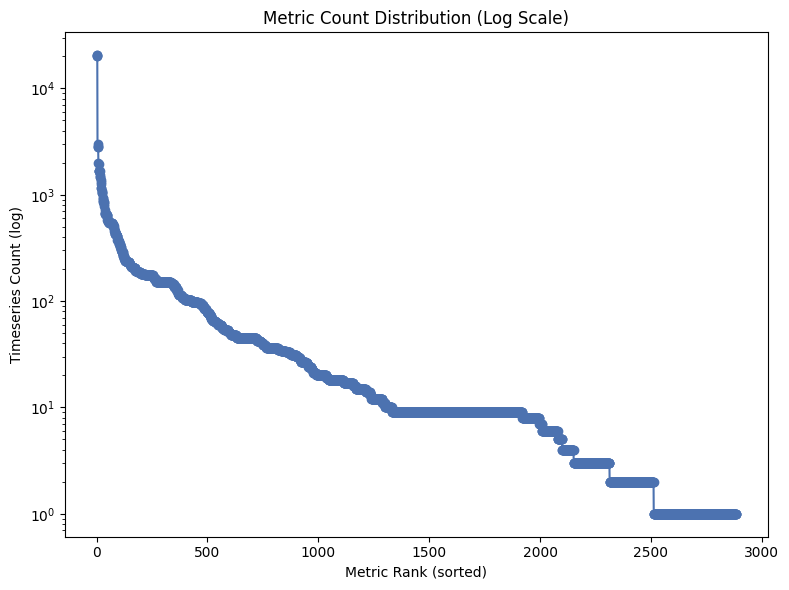

In [11]:
# Plot 2: Full distribution (log scale)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(metric_df['count'].values, marker='o', linestyle='-', color='#4C72B0')
ax.set_yscale('log')
ax.set_title('Metric Count Distribution (Log Scale)')
ax.set_xlabel('Metric Rank (sorted)')
ax.set_ylabel('Timeseries Count (log)')
plt.tight_layout()
plt.show()

The distribution of time series across metric names is highly uneven. This pattern is partly driven by services such as Loki, which expose separate series for each index and latency bucket (for example, 0.025, 0.05, 0.5, 1 seconds for synchronous operations). In a production feature set, many of these fine-grained bucketed metrics would typically be aggregated or filtered; however, they are retained here to highlight the breadth of available observability data and its potential for future development and research.

Based on prior operational experience, several metric families emerge as generally valuable indicators of service health, including:
- CPU usage metrics (e.g., `node_namespace_pod_container:container_cpu_usage_seconds_total:sum_irate`),
- CPU throttling (`container_cpu_cfs_throttled_periods_total`),
- Memory utilization metrics (`container_memory_working_set_bytes`),
- Configured CPU and memory requests and limits.

In addition, node-level metrics from the servers on which Kubernetes and the infrastructure services run provide critical context for reliability analysis and model training. The Prometheus [node-exporter](https://github.com/prometheus/node_exporter) exposes a comprehensive set of host metrics covering CPU, memory, and disk usage as well as network traffic, filesystem characteristics, and related signals. These metrics can be subjected to anomaly detection as part of root cause analysis workflows, helping to surface subtle patterns that might be missed by manual inspection alone.

### Labels
We analyze label cardinality to understand metadata diversity and potential sources of high series counts. Specifically, we:
- List available label keys from Prometheus.
- Compute unique value counts per label (cardinality).
- Highlight top-N labels by cardinality and discuss implications for storage and query performance.


In [12]:
# Fetch label names and compute cardinality
label_names = prom.get_label_names()

label_cardinality = {}
for lbl in label_names:
    try:
        values = prom.get_label_values(lbl)
        # Deduplicate and count
        label_cardinality[lbl] = len(set(values))
    except Exception as e:
        # Skip labels that error out
        continue

label_df = (pd.Series(label_cardinality, name='unique_values')
             .rename_axis('label')
             .reset_index()
             .sort_values('unique_values', ascending=False))

print(f'Total labels: {len(label_df)}')
label_df.head(20)

Total labels: 608


,label,unique_values
216,id,24721
92,container_id,22277
497,service_name,20425
309,name,20166
563,uid,15003
374,pod,13832
232,interface,10872
353,owner_name,10093
103,created_by_name,9099
15,address,8825


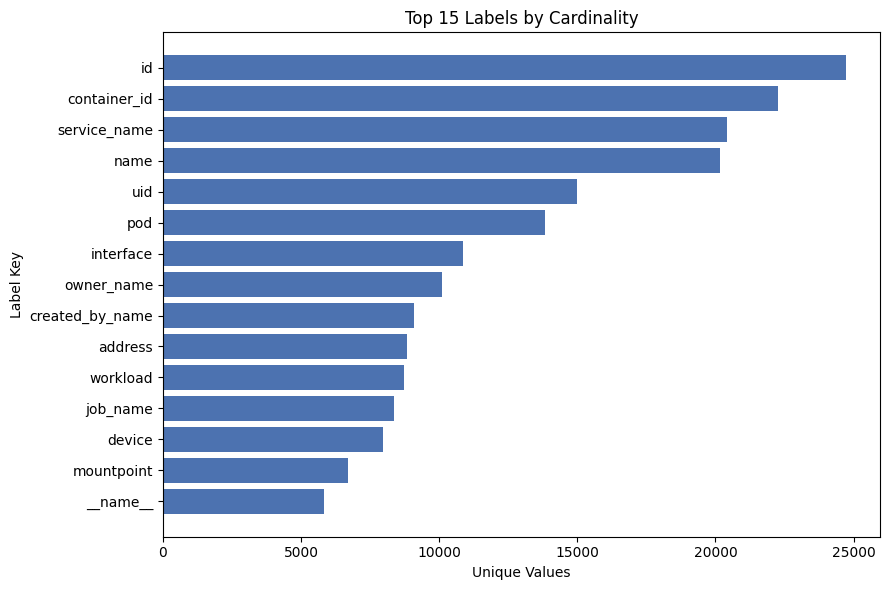

In [13]:
# Plot top-N labels by cardinality
top_n_labels = 15
top_labels_df = label_df.head(top_n_labels)

fig, ax = plt.subplots(figsize=(9, 6))
ax.barh(top_labels_df['label'][::-1], top_labels_df['unique_values'][::-1], color='#4C72B0')
ax.set_title(f'Top {top_n_labels} Labels by Cardinality')
ax.set_xlabel('Unique Values')
ax.set_ylabel('Label Key')
plt.tight_layout()
plt.show()

Although Prometheus exposes 608 distinct label keys in this environment, many of them are either redundant or not directly relevant to the objectives of this thesis. A substantial fraction arise from the way metrics are produced by heterogeneous components—such as the node-exporter mentioned above, kube-state-metrics (which reports on Kubernetes objects), and other infrastructure services—which attach fine-grained, system-specific metadata. In subsequent preprocessing and feature selection steps, most of these labels will be filtered out in favor of a smaller, semantically meaningful subset. For the analyses that follow, some of the most important labels are:
- cluster
- namespace
- pod
- container
- deployment
- daemonset
- statefulset

## Loki

In addition to numeric metrics from Prometheus, the observability stack also produces high-volume textual logs that are collected, indexed, and queried via Loki. Each log entry is associated with a timestamp, a set of labels, and an opaque message string. Labels provide the primary mechanism for scoping queries (for example by cluster, namespace, pod, container, or component) and for aggregating log volumes over time. Through this shared label space, logs and metrics can be correlated and jointly assigned to the same infrastructure entities, which is essential for later dual-modality anomaly detection and service-graph construction.

Most platform services emit structured JSON logs, while a smaller number still rely on plaintext or mixed-format messages (for example, legacy components or third-party tooling). Regardless of format, each raw log line must be transformed into a consistent representation before it can be used for modeling. In practice, this involves parsing out fields such as service or component name, log level, and the canonicalized message text, as well as normalizing timestamps and attaching cluster and namespace context.

At the time of writing, the production Loki instance holds more than 4 TB of indexed logs. This volume, combined with the diversity of logging conventions, motivates an emphasis on robust preprocessing and feature engineering rather than direct use of raw log messages. Furthermore, Loki stores valuable Kubernetes events that provide strong signals about the health and lifecycle of Pods and other Kubernetes objects. In subsequent sections, we therefore focus on label distributions, log volume summaries, and derived features that are stable under changes in logging verbosity, deployment topology, or implementation details of individual services.